In [2]:
import pandas as pd
df=pd.read_csv("./rnaseq_FPKM_UQ_all.csv", low_memory=False,index_col=1)

In [3]:
# gene expression values # 1222 by 56716
df_gene=df.iloc[:,1:56717]
df_gene.index.names=['barcode']

# clinical information   # 1222 by 82
df_clinical=df.iloc[:,56717:]
df_clinical=df_clinical.set_index('barcode')

y_label=df_clinical['sample_type'].values

from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y_label)


array([1, 1, 1, ..., 1, 1, 1])

## PCA

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# standardize gene features before applying PCA, make mean 0 and unit variance
sc=StandardScaler()
X_norm=sc.fit_transform(df_gene)

# apply PCA to gene features
pca=PCA()
X_pca=pca.fit_transform(X_norm)

temp=pca.explained_variance_ratio_.cumsum()

plt.plot(temp)
plt.xlabel('Number of Principle Components')
plt.ylabel('Proportion of Variance Explained')
plt.show();
 
sum(temp<0.80)

<Figure size 640x480 with 1 Axes>

314

In [5]:
# select the first 200 PCs and apply the transformation to data:

pca=PCA(n_components=300)
X_pca=pca.fit_transform(X_norm)

temp=pca.explained_variance_ratio_.cumsum()


In [6]:
X_pca.shape

(1222, 300)

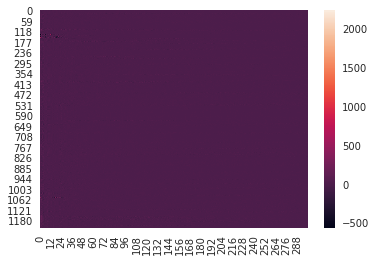

In [21]:
import seaborn as sns; sns.set()
ax = sns.heatmap(X_pca)
plt.show()

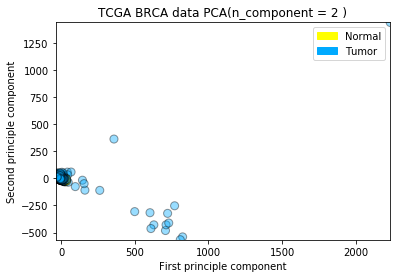

In [7]:
# visualize the PCA-transformed data

from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import numpy

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(numpy.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    

plot_labelled_scatter(X_pca, y, ['Normal','Tumor'])

plt.xlabel('First principle component')
plt.ylabel('Second principle component')
plt.title('TCGA BRCA data PCA(n_component = 2 )')
plt.show();

In [ ]:
# Visualizing PCA components
# Plotting the magnitude of each feature value for the first two principal component


fig = plt.figure(figsize=(8, 4))
plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
feature_names = list(df_gene.columns.values)

plt.gca().set_xticks(np.arange(-.5, len(feature_names)));
plt.gca().set_yticks(np.arange(0.5, 2));
plt.gca().set_xticklabels(feature_names, rotation=90, ha='left', fontsize=12);
plt.gca().set_yticklabels(['First PC', 'Second PC'], va='bottom', fontsize=12);

plt.colorbar(orientation='horizontal', ticks=[pca.components_.min(), 0, 
                                              pca.components_.max()], pad=0.65);

## Manifod Learning (for high-dim data visualization)

### Multidimensional scaling (MDS)

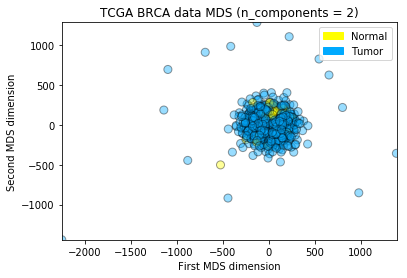

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS


mds = MDS(n_components = 2)

X_mds = mds.fit_transform(X_norm)

plot_labelled_scatter(X_mds, y, ['Normal', 'Tumor'])

plt.xlabel('First MDS dimension')
plt.ylabel('Second MDS dimension')
plt.title('TCGA BRCA data MDS (n_components = 2)');

### t-SNE

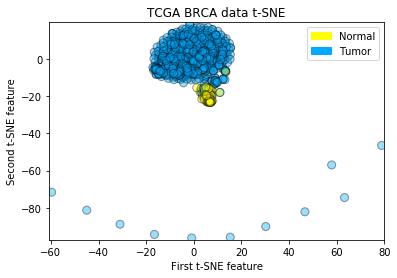

In [9]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state = 0,n_components = 2)

X_tsne = tsne.fit_transform(X_norm)

plot_labelled_scatter(X_tsne, y, 
    ['Normal', 'Tumor'])
plt.xlabel('First t-SNE feature')
plt.ylabel('Second t-SNE feature')
plt.title('TCGA BRCA data t-SNE');

## Clustering

### K-means

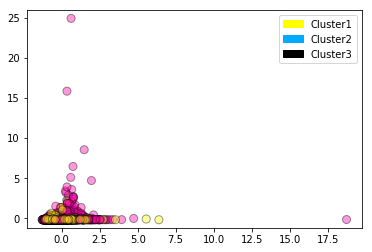

In [20]:
from sklearn.cluster import KMeans 

kmeans=KMeans(n_clusters=5)
kmeans.fit(X_norm)

plot_labelled_scatter(X_norm, kmeans.labels_, ['Cluster1', 'Cluster2','Cluster3'])

In [ ]:
kmeans.labels_

### Agglomerative Clustering

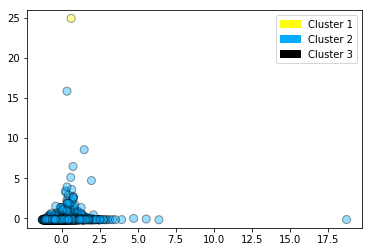

In [17]:
from sklearn.cluster import AgglomerativeClustering


cls = AgglomerativeClustering(n_clusters = 3)
cls_assignment = cls.fit_predict(X_norm)

plot_labelled_scatter(X_norm, cls_assignment, 
        ['Cluster 1', 'Cluster 2', 'Cluster 3'])

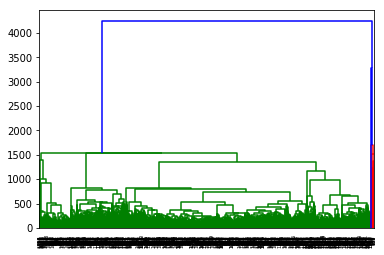

In [18]:
# Creating a dendrogram (using scipy), based on 10 selected samples

from scipy.cluster.hierarchy import ward, dendrogram
plt.figure()
dendrogram(ward(X_norm))
plt.show()

### DBSCAN

Cluster membership values:
[-1 -1 -1 ... -1 -1 -1]


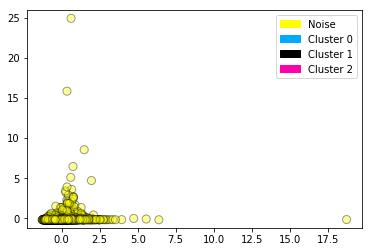

In [19]:
# No need to specify number of clusters ahead
# Good for larger dataset, efficient
# Allow to identify noise points


from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps = 2, min_samples = 2)

cls = dbscan.fit_predict(X_norm)
print("Cluster membership values:\n{}".format(cls))

plot_labelled_scatter(X_norm, cls + 1, 
        ['Noise', 'Cluster 0', 'Cluster 1', 'Cluster 2'])
